# Fashion MNIST using simple MLP, implemented with various pytorch APIs
---

In [51]:
import torch
from torchsummary import summary
import numpy as np
from tqdm import tqdm
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

## Load the data
---

Note pytorch also has an API for loading and downloading datasets, but keras version used below is more explicit

In [2]:
# load the data
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

# split train full into train and valid, and normalise so input is float between 0 and 1
x_valid, x_train = x_train_full[:5000] / 255.0, x_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# currently the data is stored as numpy array - convert to torch.Tensors
x_valid, x_train, x_test = torch.as_tensor(x_valid, dtype=torch.float), torch.as_tensor(x_train, dtype=torch.float), torch.as_tensor(x_test, dtype=torch.float)
y_valid, y_train, y_test = torch.as_tensor(y_valid, dtype=torch.float), torch.as_tensor(y_train, dtype=torch.long), torch.as_tensor(y_test, dtype=torch.long)

# manually type out the class names 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# extract input dims
dim_in = x_train[0].shape
flat_dim_in = x_train[0].shape[0] ** 2
out_dim = len(class_names)

<ipython-input-2-9912ac3915da>:9: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  x_valid, x_train, x_test = torch.as_tensor(x_valid, dtype=torch.float), torch.as_tensor(x_train, dtype=torch.float), torch.as_tensor(x_test, dtype=torch.float)


## 1. High level `torch.nn` API
---
This is the high level torch API, similar to Keras for TF. The semantics are
 1. First, define the model structure using `torch.nn.Sequential`, by passing in `torch.nn.Modules`
     - `torch.nn.Modules` are simply layers that have `.forward` and `.backward` methods
 2. Define the loss function. Many popular loss functions are available as `torch.nn.Modules` (although you can subclass to define your own if you like)
 3. Define the optimiser function. Popular optimisers are availabe in `torch.optim`.
 4. Set up the training loop:
     - Define a function which generates some iterable of batches. Note that pytorch includes utilities to do this, but for clarity we do it explicitly below
     - Define function which computes accuracy on the valid_set
     - Call the step() method of the optimiser to update the model parameters

In [54]:
# can make the model using toch.nn module

# model structure using nn API (simplest version)
m = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(784, 300),
        torch.nn.ReLU(),
        torch.nn.Linear(300, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, out_dim),
        torch.nn.Softmax(dim=1)
    )

# loss function
loss = torch.nn.CrossEntropyLoss(reduction='mean')

# function to generate minibatches
def data_generator(x, y, b):
    """
    generates minibatch from data set x,y of size b. Assumes instances are in the first dimension
    """
    idx = np.random.choice(np.arange(x.shape[0]), size=x.shape[0], replace=False)
    x_, y_ = x[idx], y[idx] 
    num_batches = int(x.shape[0] / b)
    if num_batches == 0:
        print(f"Warning, batch size is larger than data. Returning full data.")
        yield x_, y_
    for k in range(num_batches):
        start, end = k * b, (k + 1) * b
        yield x_[start:end], y_[start:end]

# utility function to compute accuracy on the valid set
def valid_accuracy(model, x_valid, y_valid):
    """
    Return accuracy on validation set
    """
    y_pred = torch.max(model.forward(x_valid), 1)[-1]
    return torch.mean((y_pred == y_valid).float())
            
# function to train using stochastic gradient descent
def sgd(model, loss_fn, x, y, batch_size, epochs, learning_rate):
    """
    Perform simple gradient descent 
    """
    
    # optimiser function
    optimiser = torch.optim.SGD(m.parameters(), lr=learning_rate)
    
    # initialise object to store training history
    history = {'loss': [], 'accuracy_train': [], 'accuracy_valid': []}
    
    for i in range(epochs):
        print(f"Starting epoch number: {i+1}")      
       
        # note we could iterate directly on the data generator, but because
        # generators have no length, can't use tqdm for progress bar nicely, 
        # so do it this way to allow for easy progress bar
        num_batches = int(x.shape[0] / batch_size)
        dg = data_generator(x, y, batch_size)
        for j  in tqdm(range(num_batches)):
            x_, y_ = next(dg)
            y_hat = model(x_)
            l = loss_fn(y_hat, y_)
            optimiser.zero_grad()
            l.backward()
            optimiser.step()
            
            # NOTE: optimiser.step() essentially does same thing as below
            # with torch.no_grad():
            #     for param in model.parameters():
            #         param -= learning_rate * param.grad
        acc_train = valid_accuracy(model, x_train, y_train)
        acc_valid = valid_accuracy(model, x_valid, y_valid)
        history['loss'].append(l.data.numpy())
        history['accuracy_train'].append(acc_train)
        history['accuracy_valid'].append(acc_valid)
        print(f"Epoch {i+1} complete | train set loss: {l.data.numpy()}, train set accuracy: {acc_train} | valid set accuracy: {acc_valid}")
    
    return history

# print summary of model
summary(m, dim_in)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
           Softmax-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


In [55]:
history = sgd(m, loss, x_train, y_train, 128, 10, 0.1)

  0%|          | 1/429 [00:00<00:45,  9.44it/s]

Starting epoch number: 1


  0%|          | 1/429 [00:00<00:48,  8.80it/s]

Epoch 1 complete | train set loss: 1.9631543159484863, train set accuracy: 0.5332727432250977 | valid set accuracy: 0.5351999998092651
Starting epoch number: 2


  1%|          | 3/429 [00:00<00:15, 26.87it/s]

Epoch 2 complete | train set loss: 1.7694286108016968, train set accuracy: 0.7163636088371277 | valid set accuracy: 0.7149999737739563
Starting epoch number: 3


  0%|          | 1/429 [00:00<00:52,  8.12it/s]

Epoch 3 complete | train set loss: 1.7153927087783813, train set accuracy: 0.7654363512992859 | valid set accuracy: 0.769599974155426
Starting epoch number: 4


  0%|          | 1/429 [00:00<00:51,  8.30it/s]

Epoch 4 complete | train set loss: 1.699120283126831, train set accuracy: 0.7869454622268677 | valid set accuracy: 0.7897999882698059
Starting epoch number: 5


  1%|          | 3/429 [00:00<00:15, 27.87it/s]

Epoch 5 complete | train set loss: 1.7001309394836426, train set accuracy: 0.7918182015419006 | valid set accuracy: 0.7975999712944031
Starting epoch number: 6


  0%|          | 2/429 [00:00<00:21, 19.98it/s]

Epoch 6 complete | train set loss: 1.655104398727417, train set accuracy: 0.8004727363586426 | valid set accuracy: 0.807200014591217
Starting epoch number: 7


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 7 complete | train set loss: 1.6675186157226562, train set accuracy: 0.8049818277359009 | valid set accuracy: 0.8113999962806702
Starting epoch number: 8


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 8 complete | train set loss: 1.6918971538543701, train set accuracy: 0.8036545515060425 | valid set accuracy: 0.8041999936103821
Starting epoch number: 9


  1%|          | 3/429 [00:00<00:18, 23.00it/s]

Epoch 9 complete | train set loss: 1.6508830785751343, train set accuracy: 0.8115636110305786 | valid set accuracy: 0.8167999982833862
Starting epoch number: 10


100%|██████████| 429/429 [00:07<00:00, 58.45it/s]


Epoch 10 complete | train set loss: 1.6601086854934692, train set accuracy: 0.8113272786140442 | valid set accuracy: 0.817799985408783


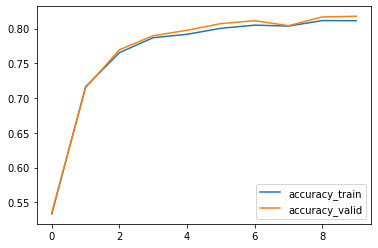

In [57]:
plt.plot(history['accuracy_train'], label='accuracy_train')
plt.plot(history['accuracy_valid'], label='accuracy_valid')
plt.legend()
